In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO

In [48]:
def rd(x,y=0):
    ''' A classical mathematical rounding by Voznica '''
    try:
        m = int('1'+'0'*y) # multiplier - how many positions to the right
        q = x*m # shift to the right by multiplier
        c = int(q) # new number
        i = int( (q-c)*10 ) # indicator number on the right
        if i >= 5:
            c += 1
        result = '{num:.{prec}f}'.format(num=c/m,prec=y)
    except:
        result = ''
    return result

In [57]:
def getBarChart(df, columns = [], type='v', precision=0, normalize=False, title='Title', label='Label', width=0.8, rotation=0, figsize=(5, 5), html=False, file=''):
    '''Tato funkce vytváří grafy s popisky hodnot'''
    if len(columns) == 0:
        columns = df.columns
    if normalize:
        df = df[columns].div(df[columns].sum(axis=1), axis=0)*100
    else:
        df = df[columns]
    #ind = np.arange(len(df.index))
    if type == 'h' or type == 'hr' or type == 'v' or type == 'vr':
        if type == 'vr' or type == 'hr':
            df = df[::-1]
            type = type[0]
        fig, ax = plt.subplots(figsize = figsize)
        rectss = []
        bottom = np.zeros(len(df))
        if type == 'v':
            for column in columns:
                rectss.append(plt.bar(x=df.index, height=df[column], bottom=bottom, width=width, label=column))
                bottom += np.array(df[column])
            bottom = np.zeros(len(df))
            for rects in rectss:
                bott = []
                for i, rect in enumerate(rects):
                    if len(columns) == 1:
                        ax.annotate(text=rd(rect.get_height(), precision), xy=(rect.get_x() + rect.get_width()/2, rect.get_height()), ha='center', va='bottom')
                    else:
                        ax.annotate(text=rd(rect.get_height(), precision), xy=(rect.get_x() + rect.get_width()/2, rect.get_height()/2 + bottom[i]), ha='center', va='center')
                    bott.append(rect.get_height())
                bottom += np.array(bott)
            if rotation > 0 and rotation < 90:
                plt.xticks(rotation = rotation, rotation_mode='anchor', ha='right')
            else:
                plt.xticks(rotation = rotation)
            plt.ylabel(label)
        if type == 'h':
            for column in columns:
                rectss.append(plt.barh(y=df.index, width=df[column], left=bottom, height=width, label=column))
                bottom += np.array(df[column])
            bottom = np.zeros(len(df))
            for rects in rectss:
                bott = []
                for i, rect in enumerate(rects):
                    if len(columns) == 1:
                        ax.annotate(text=rd(rect.get_width(),precision), xy=(rect.get_width()+bottom[i], rect.get_y()+rect.get_height()/2), ha='left', va='center')
                    else:
                        ax.annotate(text=rd(rect.get_width(),precision), xy=(rect.get_width()/2+bottom[i], rect.get_y()+rect.get_height()/2), ha='center', va='center')
                    bott.append(rect.get_width())
                bottom += np.array(bott)
            if rotation < 0 or rotation > 90:
                plt.yticks(rotation = rotation, rotation_mode='anchor', ha='right')
            else:
                plt.yticks(rotation = rotation)
            plt.xlabel(label)
        plt.title(title)
        ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1), ncol=1, fancybox=True, shadow=True)
        #plt.show()
        if file != '':
            fig.savefig(file, dpi=fig.dpi, bbox_inches='tight')
        if html:
            buf = BytesIO()
            fig.savefig(buf, format="png", bbox_inches='tight')
            # Embed the result in the html output.
            data = base64.b64encode(buf.getbuffer()).decode("ascii")
            return f"<img src='data:image/png;base64,{data}'/>"
    else:
        raise Exception("Sorry, wrong type(only accept 'h', 'hr', 'v', 'vr')")

In [50]:
df = pd.DataFrame({'Boys': [67, 78],
                         'Girls': [72, 80], },
                        index=['First Year', 'Second Year'])
df

,Boys,Girls
First Year,67,72
Second Year,78,80


<Axes: >

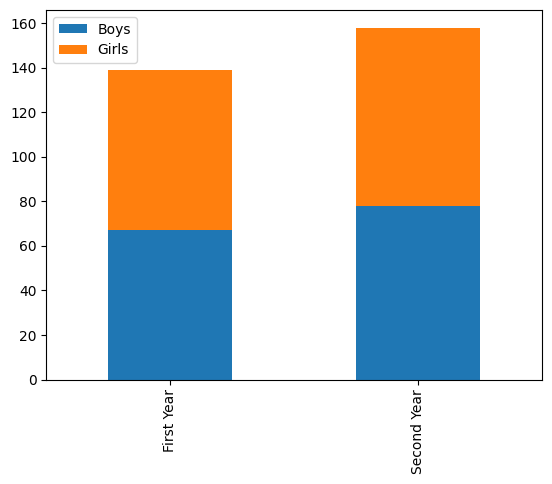

In [51]:
df.plot(kind='bar', stacked=True)

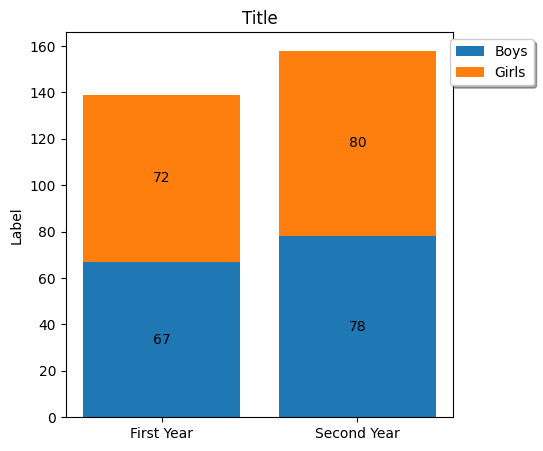

In [52]:
getBarChart(df)

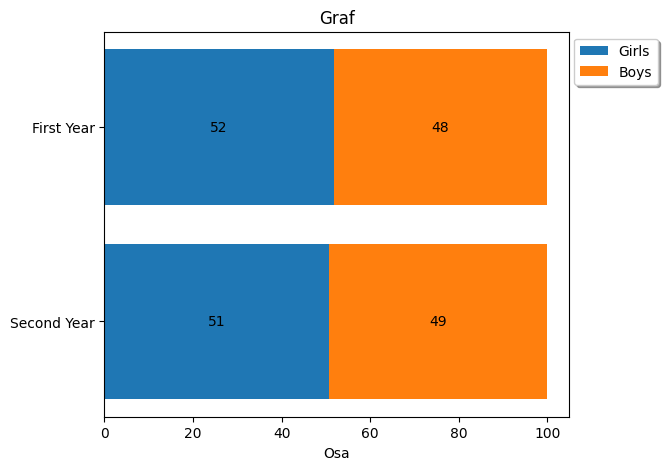

In [53]:
#columns = [], type='v', precision=0, normalize=False, title='Graf', label='Osa', width=0.8, rotation=0, figsize=(5, 5), html=False
html = getBarChart(df, columns=['Girls', 'Boys'], type='hr', precision=0, normalize=True, title='Graf', label='Osa', width=0.8, rotation=0, figsize=(6, 5), html=True)

In [54]:
from ipywidgets import widgets, Layout, HBox, HTML
HTML(html)

HTML(value="<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAApsAAAHWCAYAAAA4vEJLAAAAOXRFWHRTb2Z0d2FyZQ…

""
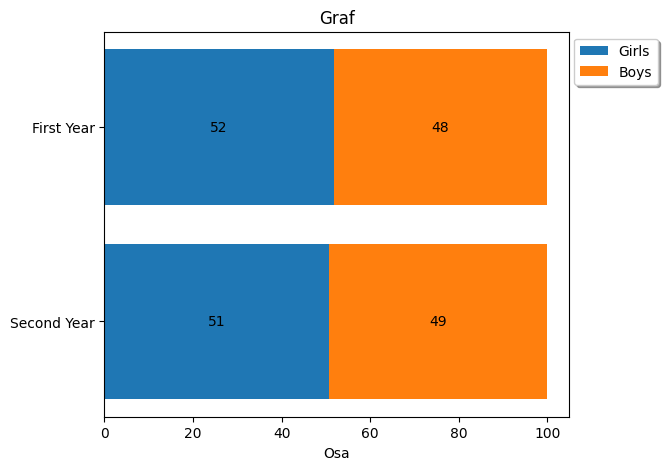

In [55]:
html

In [30]:
with open ('plot.html', 'w') as file:
    file.write(html)

# https://gist.github.com/FlorianRhiem/dd3ae199da5ab5ff46d0


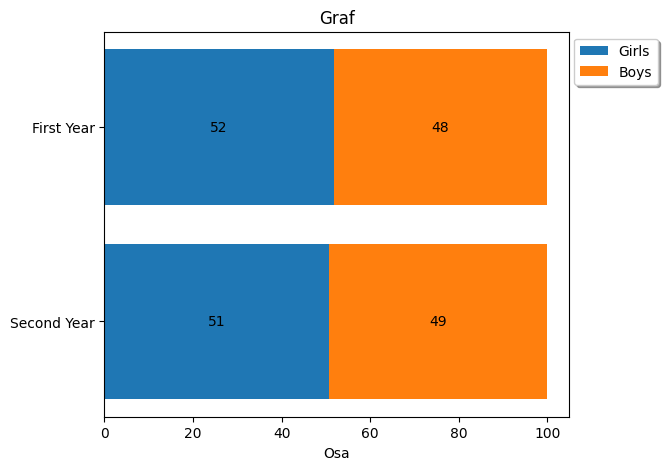

In [59]:
# dodělat plot.png
#plt.savefig('plot.png', bbox_inches='tight')
getBarChart(df, columns=['Girls', 'Boys'], type='hr', precision=0, normalize=True, title='Graf', label='Osa', width=0.8, rotation=0, figsize=(6, 5), html=False, file='plot.png')


![title](plot.png)